In [1]:
import os
import pickle
import glob

import numpy as np
import pandas as pd
import math
from natsort import natsorted

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patches as patches
from matplotlib.path import Path
from matplotlib import colors
from matplotlib.colors import ListedColormap

import seaborn as sns

from PIL import Image, ImageDraw

from tifffile import imread
from tifffile import imsave

from umap import UMAP
import hdbscan
from joblib import Memory

import napari
import dask.array as da
import zarr
import tifffile

from skimage.util import img_as_float
from skimage.color import gray2rgb

In [2]:
# MUST INITIALLY RUN THIS SCRIPT IN IPYTHON TO UPDATE ROI SELECTIONS

In [3]:
# TOPACIO sample number
sample = '840063_0110'

In [4]:
def single_channel_pyramid(tiff_path, channel):

    target_filepath = tiff_path
    tiff = tifffile.TiffFile(target_filepath, is_ome=False)

    pyramid = [
        zarr.open(s[channel].aszarr())
        for s in tiff.series[0].levels
        ]

    pyramid = [
        da.from_zarr(z)
        for z in pyramid
        ]

    return pyramid

In [5]:
def categorical_cmap(numUniqueSamples, numCatagories, cmap='tab10', continuous=False):

    numSubcatagories = math.ceil(numUniqueSamples/numCatagories)

    if numCatagories > plt.get_cmap(cmap).N:
        raise ValueError('Too many categories for colormap.')
    if continuous:
        ccolors = plt.get_cmap(cmap)(np.linspace(0, 1, numCatagories))
    else:
        ccolors = plt.get_cmap(cmap)(np.arange(numCatagories, dtype=int))
        # rearrange hue order to taste
        cd = {
            'B': 0, 'O': 1, 'G': 2, 'R': 3, 'Pu': 4,
            'Br': 5, 'Pi': 6, 'Gr': 7, 'Y': 8, 'Cy': 9,
            }
        myorder = [
            cd['B'], cd['O'], cd['G'], cd['Pu'], cd['Y'],
            cd['R'], cd['Cy'], cd['Br'], cd['Gr'], cd['Pi']
            ]
        ccolors = [ccolors[i] for i in myorder]

        # use Okabe and Ito color-safe palette for first 6 colors
        # ccolors[0] = np.array([0.91, 0.29, 0.235]) #E84A3C
        # ccolors[1] = np.array([0.18, 0.16, 0.15]) #2E2926
        ccolors[0] = np.array([0.0, 0.447, 0.698, 1.0])  # blue
        ccolors[1] = np.array([0.902, 0.624, 0.0, 1.0])  # orange
        ccolors[2] = np.array([0.0, 0.620, 0.451, 1.0])  # bluish green
        ccolors[3] = np.array([0.8, 0.475, 0.655, 1.0])  # reddish purple
        ccolors[4] = np.array([0.941, 0.894, 0.259, 1.0])  # yellow
        ccolors[5] = np.array([0.835, 0.369, 0.0, 1.0])  # vermillion

    cols = np.zeros((numCatagories * numSubcatagories, 3))
    for i, c in enumerate(ccolors):
        chsv = colors.rgb_to_hsv(c[:3])
        arhsv = np.tile(chsv, numSubcatagories).reshape(numSubcatagories, 3)
        arhsv[:, 1] = np.linspace(chsv[1], 0.25, numSubcatagories)
        arhsv[:, 2] = np.linspace(chsv[2], 1, numSubcatagories)
        rgb = colors.hsv_to_rgb(arhsv)
        cols[i * numSubcatagories:(i + 1) * numSubcatagories, :] = rgb
    cmap = colors.ListedColormap(cols)

    # trim colors if necessary
    if len(cmap.colors) > numUniqueSamples:
        trim = len(cmap.colors) - numUniqueSamples
        cmap_colors = cmap.colors[:-trim]
        cmap = colors.ListedColormap(cmap_colors, name='from_list', N=None)

    return cmap

In [6]:
# output dir
save_dir = '/Users/greg/Dropbox (HMS)/Baker_QC_2021/script_output/bunching_artifact'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [7]:
# assign file path to TOPACIO OME-TIFF (THIS IMAGE IS NOT BACKGROUND SUBTRACTED)
img_path = (f'/Volumes/My Book/bunching_artifact/{sample}.ome.tif')

# read markers.csv
markers = pd.read_csv('/Volumes/My Book/cylinter_input/TOPACIO_FINAL/markers.csv')

# read raw TOPACIO sc dataset
sc_data = pd.read_csv('/Volumes/My Book/bunching_artifact/unmicst2-840063_0110.csv')
sc_data.columns = [i.split('_cellRingMask')[0] for i in sc_data.columns]

In [8]:
# isolate immunomarker channels
exclude = ['antiRat', 'antiRabbit', 'antiGoat', 'pSTAT1', 'Ki67', 'STING', 'pTBK1', 'pSTAT3', 'PCNA', 'HLAA', 'cPARP']
include = [i for i in sc_data.columns if 'DNA' not in i if i not in exclude if i in list(markers['marker_name'])]

# log-transform antibody expression data
transformed_data = np.log10(sc_data[include] + 0.00001)
sc_data.update(transformed_data)

In [9]:
# define image crop window
row_min = 10000
row_max = 14000
col_min = 17000
col_max = 20000

# select cells within cropped image
data_crop = sc_data[
    (sc_data['X_centroid'].between(col_min, col_max)) &
    (sc_data['Y_centroid'].between(row_min, row_max))
    ].copy()

# transform x, y coordinates of cells within cropped image
data_crop['X_centroid'] = data_crop['X_centroid']-col_min
data_crop['Y_centroid'] = data_crop['Y_centroid']-row_min

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


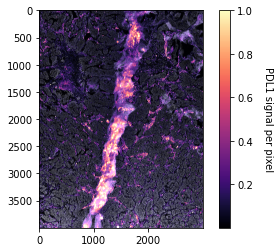

In [10]:
# read DNA1 image for matplotlib plot and crop
dna = imread(img_path, key=0)
dna_float = img_as_float(dna)
dna_float = (dna_float - np.min(dna_float)) / (np.max(dna_float) - np.min(dna_float))  # normalize 0-1
dna_crop = dna_float[row_min:row_max, col_min:col_max]
dna_crop_rgb = gray2rgb(dna_crop)

# read PDL1 image
pdl1 = imread(img_path, key=6)
pdl1_float = img_as_float(pdl1)
pdl1_float = (pdl1_float - np.min(pdl1_float)) / (np.max(pdl1_float) - np.min(pdl1_float))  # normalize 0-1
pdl1_crop = pdl1_float[row_min:row_max, col_min:col_max]

bottom_cutoff = 0.01
top_cutoff = 0.1
pdl1_crop = np.clip(pdl1_crop, bottom_cutoff, top_cutoff)
pdl1_crop = (pdl1_crop - np.min(pdl1_crop)) / (np.max(pdl1_crop) - np.min(pdl1_crop))  # normalize 0-1

pdl1_crop_rgb = plt.cm.magma(pdl1_crop) # converts to RGBA automatically
pdl1_crop_rgb = pdl1_crop_rgb[:, :, 0:3]  # drop alpha dimension

dna_crop_rgb /= 2.0  # modify DNA intensity if needed
dna_crop_rgb += pdl1_crop_rgb

plt.imshow(dna_crop_rgb, cmap='magma')
cbar = plt.colorbar()
cbar.set_alpha(1.0)
cbar.set_label('PDL1 signal per pixel', labelpad=20, rotation=270)
cbar.draw_all()
plt.savefig(os.path.join(save_dir, 'pdl1.png'), dpi=1000)
plt.savefig(os.path.join(save_dir, 'pdl1.pdf'))
plt.show()
plt.close('all')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


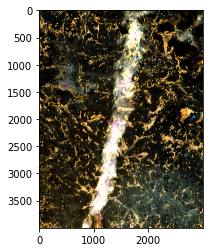

In [11]:
# re-generate DNA RGB
dna_crop_rgb = gray2rgb(dna_crop)
dna_crop_rgb /= 3.0  # dim DNA 

# re-generate PDL1 RGB
pdl1_crop = pdl1_float[row_min:row_max, col_min:col_max].copy()
bottom_cutoff = 0.02
top_cutoff = 0.1
pdl1_crop = np.clip(pdl1_crop, bottom_cutoff, top_cutoff)
pdl1_crop = (pdl1_crop - np.min(pdl1_crop)) / (np.max(pdl1_crop) - np.min(pdl1_crop))  
pdl1_crop_rgb = gray2rgb(pdl1_crop)
pdl1_crop_rgb *= (0.580, 0.125, 0.580)  # BOP purple

# pdl1_crop_rgb = plt.cm.magma(pdl1_crop) # converts to RGBA automatically
# pdl1_crop_rgb = pdl1_crop_rgb[:, :, 0:3]  # drop alpha dimension

# dna_crop_rgb += pdl1_crop_rgb

# read CD163 image of target core and crop to target size
# cd163 = imread(img_path, key=17)
# cd163_float = img_as_float(cd163)
# cd163_float = (cd163_float - np.min(cd163_float)) / (np.max(cd163_float) - np.min(cd163_float))  # normalize 0-1
# cd163_crop = cd163_float[row_min:row_max, col_min:col_max].copy()
# bottom_cutoff = 0.0 
# top_cutoff = 0.5
# cd163_crop = np.clip(cd163_crop, bottom_cutoff, top_cutoff)
# cd163_crop = (cd163_crop - np.min(cd163_crop)) / (np.max(cd163_crop) - np.min(cd163_crop))  
# cd163_crop_rgb = gray2rgb(cd163_crop)
# cd163_crop_rgb *= (0.973, 0.678, 0.125)

# pdl1_crop_rgb += cd163_crop_rgb

# read CD4 image of target core and crop to target size
cd4 = imread(img_path, key=21)
cd4_float = img_as_float(cd4)
cd4_float = (cd4_float - np.min(cd4_float)) / (np.max(cd4_float) - np.min(cd4_float))  # normalize 0-1
cd4_crop = cd4_float[row_min:row_max, col_min:col_max].copy()
bottom_cutoff = 0.015
top_cutoff = 0.05
cd4_crop = np.clip(cd4_crop, bottom_cutoff, top_cutoff)
cd4_crop = (cd4_crop - np.min(cd4_crop)) / (np.max(cd4_crop) - np.min(cd4_crop))  
cd4_crop_rgb = gray2rgb(cd4_crop)
cd4_crop_rgb *= (0.973, 0.678, 0.125)  # BOP orange

pdl1_crop_rgb += cd4_crop_rgb

# read CD57 image of target core and crop to target size
cd57 = imread(img_path, key=29)
cd57_float = img_as_float(cd57)
cd57_float = (cd57_float - np.min(cd57_float)) / (np.max(cd57_float) - np.min(cd57_float))  # normalize 0-1
cd57_crop = cd57_float[row_min:row_max, col_min:col_max].copy()
bottom_cutoff = 0.015 
top_cutoff = 0.05
cd57_crop = np.clip(cd57_crop, bottom_cutoff, top_cutoff)
cd57_crop = (cd57_crop - np.min(cd57_crop)) / (np.max(cd57_crop) - np.min(cd57_crop))  
cd57_crop_rgb = gray2rgb(cd57_crop)
cd57_crop_rgb *= (0.125, 0.678, 0.973)  # BOP blue

pdl1_crop_rgb += cd57_crop_rgb

#CD57
#CD11b
#CD8
#ECAD
#CD3

plt.imshow(pdl1_crop_rgb)
plt.grid(False)

plt.savefig(os.path.join(save_dir, 'context.png'), dpi=800)
plt.savefig(os.path.join(save_dir, 'context.pdf'))
plt.show()
plt.close('all')

In [12]:
# open cropped image in Napari to gate on tissue bunching if not already done 
if os.path.exists(os.path.join(save_dir, f'polygon_dict.pkl')):
    f = open(os.path.join(save_dir, f'polygon_dict.pkl'), 'rb')
    polygon_dict = pickle.load(f)
    shapes = [polygon_dict[i][0] for
              i in range(0, len(polygon_dict.keys()))]
    polygons = [polygon_dict[i][1] for
              i in range(0, len(polygon_dict.keys()))]

else:
    viewer = napari.view_image(dna_crop, opacity=0.5, rgb=False, name='DNA1')

    viewer.add_image(
        seg_crop, rgb=False, blending='additive',opacity=0.5,
        colormap='green', visible=False, name='segmentation'
        )

    viewer.add_image(cd8a_crop, rgb=False, blending='additive',colormap='magma', visible=True, name='CD8a')

    selection_layer = viewer.add_shapes(
        shape_type='polygon', ndim=2, face_color=[1.0, 1.0, 1.0, 0.2],
        edge_color=[0.0, 0.66, 1.0, 1.0], edge_width=10.0, name='ROI(s)'
        )
    
    # view existing ROIs in Napari
    # selection_layer = viewer.add_shapes(
    #     data=polygons,
    #     shape_type=shapes,
    #     ndim=2,
    #     face_color=[0.0, 1.0, 0.0, 0.0],  # [1.0, 1.0, 1.0, 0.2]
    #     edge_color=[0.0, 1.0, 0.0, 1.0], # [0.0, 0.66, 1.0, 1.0]
    #     edge_width=20.0,
    #     name='ROI(s)')

    napari.run()

    polygon_dict = dict(zip([i for i in range(len(selection_layer.shape_type))],
                      [i for i in zip(selection_layer.shape_type, selection_layer.data)])
                  )
    print(polygon_dict)
    f = open(os.path.join(save_dir, f'polygon_dict.pkl'), 'wb')
    pickle.dump(polygon_dict, f)
    f.close()

In [13]:
# isolate core data within ROI bounds
roi_data = data_crop[['X_centroid', 'Y_centroid', 'CellID']].astype(int)
roi_data['tuple'] = list(zip(roi_data['X_centroid'], roi_data['Y_centroid']))

cell_ids_dict = {}

for key, (shape_type, verts) in polygon_dict.items():

    selection_verts = np.round(verts).astype(int)
    
    # create pillow image to convert into boolean mask
    img = Image.new('L', (dna_crop.shape[1], dna_crop.shape[0]))

    if shape_type == 'ellipse':
        
        vertices, triangles = triangulate_ellipse(selection_verts)
        
        # flip 2-tuple coordinates returned by
        # triangulate_ellipse() to draw image mask
        vertices = [tuple(reversed(tuple(i))) for i in vertices]

        # update pillow image with polygon
        ImageDraw.Draw(img).polygon(
            vertices, outline=1, fill=1
            )
    
    else:
        vertices = list(tuple(
            zip(selection_verts[:, 1],
                selection_verts[:, 0])
            ))

        # update pillow image with polygon
        ImageDraw.Draw(img).polygon(
            vertices, outline=1, fill=1
            )
    
    # convert pillow image into boolean numpy array
    mask = np.array(img, dtype=bool)
    
    # use numpy fancy indexing to get centroids
    # where boolean mask is True
    xs, ys = zip(*roi_data['tuple'])
    inter = mask[ys, xs]

    cell_ids = set(roi_data['CellID'][inter])
 
    cell_ids_dict[key] = cell_ids

In [14]:
# perform clustering
clus_data = data_crop[include + ['CellID']].copy()
clus_data = clus_data.sample(frac=1.0, random_state=3)

if os.path.exists(os.path.join(save_dir, 'embedding.npy')):
    embedding = np.load(os.path.join(save_dir, 'embedding.npy'))
    clus_data['emb1'] = embedding[:, 0]
    clus_data['emb2'] = embedding[:, 1]
else:
    print('Performing UMAP embedding...')
    embedding = UMAP(random_state=3, min_dist=0.1, repulsion_strength=1.0).fit_transform(clus_data[include])
    clus_data['emb1'] = embedding[:, 0]
    clus_data['emb2'] = embedding[:, 1]

    np.save(os.path.join(save_dir, 'embedding'), embedding)

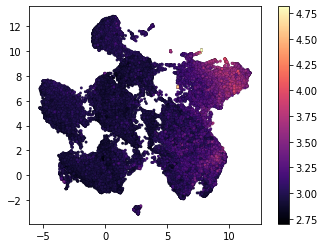

In [15]:
# plot clustering
fig, ax = plt.subplots()
sc = plt.scatter(clus_data['emb1'], clus_data['emb2'], c=clus_data['PDL1'], cmap='magma', s=7.5, ec='k', lw=0.1)
plt.colorbar(sc)
ax.set_aspect('equal')
plt.savefig(os.path.join(save_dir, 'cmap.png'), dpi=1000)
plt.show()
plt.close('all')

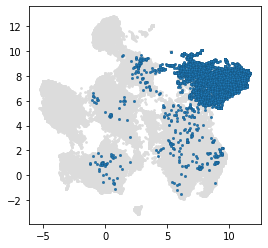

In [16]:
in_roi = clus_data[clus_data['CellID'].isin(cell_ids)]
out_roi = clus_data[~clus_data['CellID'].isin(cell_ids)]
# pink '#FF6EB0'
fig, ax = plt.subplots()
plt.scatter(out_roi['emb1'], out_roi['emb2'], c='gainsboro', s=7.5, ec=[0.0, 0.0, 0.0], lw=0.0, alpha=1.0)
plt.scatter(in_roi['emb1'], in_roi['emb2'], c='tab:blue', s=7.5, ec='k', lw=0.1, alpha=1.0)
ax.set_aspect('equal')
plt.savefig(os.path.join(save_dir, 'gating.png'), dpi=1000)
plt.show()
plt.close('all')

55619


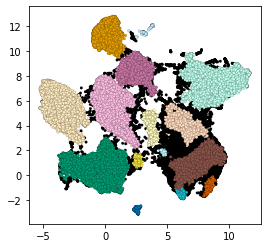

In [17]:
clustering = hdbscan.HDBSCAN(min_cluster_size=100).fit(clus_data[['emb1', 'emb2']])
clus_data['cluster'] = clustering.labels_

# generate categorical cmap for clusters
cmap = categorical_cmap(
    numUniqueSamples=len(clus_data['cluster'].unique()),
    numCatagories=10,
    cmap='tab10', continuous=False)

cmap = ListedColormap(
    np.insert(
        arr=cmap.colors, obj=0,
        values=[0, 0, 0], axis=0)
        )

# trim cmap to # unique samples
trim = (
    len(cmap.colors) - len(
        clus_data['cluster'].unique())
    )
cmap = ListedColormap(
    cmap.colors[:-trim]
    )

sample_dict = dict(
    zip(
        natsorted(
            clus_data['cluster'].unique()),
        list(range(len(clus_data['cluster']
             .unique()))))
        )

c = [sample_dict[i] for i
     in clus_data['cluster']]

print(len(clus_data))

fig, ax = plt.subplots()
plt.scatter(clus_data['emb1'], clus_data['emb2'], c=c, cmap=cmap, s=7.5, ec='k', lw=0.1, alpha=1.0)
ax.set_aspect('equal')
plt.savefig(os.path.join(save_dir, 'clustering.png'), dpi=1000)
plt.show()
plt.close('all')

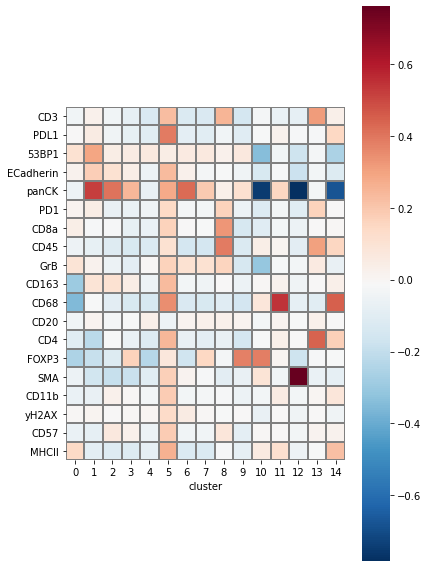

In [18]:
fig, ax = plt.subplots(figsize=(6, 8))
heatmap = clus_data[include + ['cluster']].groupby(['cluster']).mean()
heatmap.drop(-1, axis=0, inplace=True)
heatmap2 = (heatmap - heatmap.mean()).T
sns.heatmap(heatmap2, linecolor='grey', lw=1.0, cmap='RdBu_r', square=True, ax=ax)
plt.tight_layout()
plt.savefig(os.path.join(save_dir, 'heatmap.pdf'))
plt.show()
plt.close('all')